<a href="https://colab.research.google.com/github/jasreman8/LLMs-For-RAGs/blob/main/LLM_Assistant_for_Document_based_QandA_using_RAG_OpenAI_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Objective

- Build an LLM assistant for document-based Q&A using retrieval-augmented generation.

# Setup

In [1]:
!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-community==0.3.19 \
                langchain-chroma==0.2.2 \
                langchain-openai==0.3.9 \
                chromadb==0.6.3 \
                posthog==2.4.2

In [2]:
import chromadb

from openai import OpenAI

from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

from google.colab import userdata
import os

In [3]:
openai_api_key = userdata.get('OPEN_API_KEY')

In [4]:
client = OpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1"
)

In [5]:
model_name = 'gpt-4o-mini'

In [6]:
embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='text-embedding-3-small'
)

# Load the Vector Database

Since we persisted the database to to a folder, we can upload this database to this Colab instance and point a Chroma instance to this database.

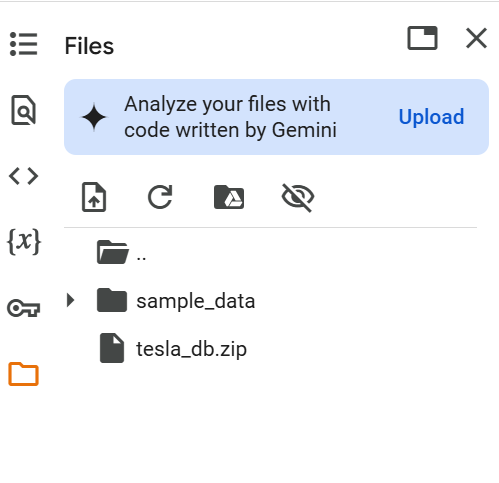

In practise, the database is maintained as a separate entity and CRUD operations are managed just as one would for normal databases (e.g., relational databases).

Now that the database is uploaded onto the Colab instance, we can unzip it and attach a retriever.

In [7]:
# !unzip tesla_db-1.zip

In [8]:
chromadb_client = chromadb.PersistentClient(
    path="./tesla_db"
)

In [9]:
# this is the step where a LangChain vector is “mounted” on top of on-disk Chroma DB and point it at a specific collection for the Tesla 10-Ks.
tesla_10k_collection = 'tesla-10k-2019-to-2023'
vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./tesla_db"
)

In [10]:
# You’re turning your Chroma vector store into a LangChain retriever and telling it to do a plain k-NN similarity search that returns the top 5 most similar chunks.

retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

# RAG Q&A

## Prompt Design

The RAG system message should clearly communicate to the LLM that the input will include a user query along with the necessary context information to address that query. Additionally, the response should rely solely on the context information provided.

In [11]:
qna_system_message = """
You are an assistant to a financial services firm who answers user queries on annual reports.
User input will have the context required by you to answer user queries.
This context will be delimited by: <Context> and </Context>.
The context contains references to specific portions of a document relevant to the user query.

User queries will be delimited by: <Question> and </Question>.

Please answer user queries only using the context provided in the input.
Do not mention anything about the context in your final answer. Your response should only contain the answer to the question.

If the answer is not found in the context, respond "I don't know".
"""

In [12]:
qna_user_message_template = """
<Context>
Here are some documents that are relevant to the question mentioned below.
{context}
</Context>

<Question>
{question}
</Question>
"""

## Retrieving relevant documents

In [13]:
user_query = "What was the annual revenue of the company in 2022?"

In [14]:
# This code snippet runs a semantic search and returns the top-k chunks (as Document objects) from Tesla-10k-2019-to-2023 collection
relevant_document_chunks = retriever.invoke(user_query)

In [15]:
len(relevant_document_chunks)

5

We can inspect the first document like so:

In [16]:
for document in relevant_document_chunks:
    print(document.page_content.replace("\t", " "))
    break

systems.
In 2020, we recognized total revenues of $31.54 billion, representing an increase of $6.96 billion compared to the prior year. We continue to ramp
production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue
growth.
In 2020, our net income attributable to common stockholders was $721 million, representing a favorable change of $1.58 billion compared to the prior
year. In 2020, our operating margin was 6.3%, representing a favorable change of 6.6% compared to the prior year. We continue to focus on operational
efficiencies, while we have seen an acceleration of non-cash stock-based compensation expense due to a rapid increase in our market capitalization and updates
to our business outlook.
We ended 2020 with $19.38 billion in cash and cash equivalents, representing an increase of $13.12 billion from the end of 2019. Our cash flows from
operating activities during 2020 was $5.94 billion

## Composing the response

To compose the response to user queries, we assemble the prompt that uses the system message defined above and the dynamically retrieved context for the user query.

In [17]:
user_query = "What was the annual revenue of the company in 2022?"

 This is a classic RAG (Retrieval Augmented Generation) call:
  - It retrieves relevant 10K chunks,
  - builds a context block,
  - stuffs that into a chat prompt,
  - calls the model with temperature = 0 (deterministic -> creativity 0),
  - prints the model's answer.

In [18]:
relevant_document_chunks = retriever.invoke(user_query)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = "\n---\n".join(context_list)

prompt = [
    {'role': 'developer', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_query
        )
    }
]

try:
    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

The annual revenue of the company in 2022 was $81.46 billion.


# A RAG Assistant

Let us put together the code in this notebook into a file `rag-chat.py` that will open up a basic command line chat interface whenever it is run at the terminal. This naive implementation neverthless illustrates how document Q&A could be automated.

In [19]:
os.environ['openai_api_key'] = openai_api_key

In [20]:
%%writefile rag-chat.py
import os
import chromadb

from openai import OpenAI

from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

from google.colab import userdata

model_name = 'gpt-4o-mini'
tesla_10k_collection = 'tesla-10k-2019-to-2023'
openai_api_key = os.environ.get('openai_api_key')

client = OpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1"
)

embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='text-embedding-3-small'
)

chromadb_client = chromadb.PersistentClient(
    path="./tesla_db"
)

vectorstore_persisted = Chroma(
    collection_name=tesla_10k_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./tesla_db"
)

retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

qna_system_message = """
You are an assistant to a financial services firm who answers user queries on annual reports.
User input will have the context required by you to answer user queries.
This context will be delimited by: <Context> and </Context>.
The context contains references to specific portions of a document relevant to the user query.

User queries will be delimited by: <Question> and </Question>.

Please answer user queries only using the context provided in the input.
Do not mention anything about the context in your final answer. Your response should only contain the answer to the question.

If the answer is not found in the context, respond "I don't know".
"""

qna_user_message_template = """
<Context>
Here are some documents that are relevant to the question mentioned below.
{context}
</Context>

<Question>
{question}
</Question>
"""

def respond(user_query):
    relevant_document_chunks = retriever.invoke(user_query)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = "\n---\n".join(context_list)

    prompt = [
        {'role': 'developer', 'content': qna_system_message},
        {
            'role': 'user', 'content': qna_user_message_template.format(
             context=context_for_query,
             question=user_query)
        }
    ]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=prompt,
            temperature=0
        )

        answer = response.choices[0].message.content.strip()
    except Exception as e:
        answer = f'Sorry, I encountered the following error: \n {e}'

    return answer

def main():
    """
    Runs the main interactive loop for the Q&A system.

    This function initializes the conversation history, continuously prompts
    the user for queries, processes the queries using the `respond` function,
    and displays the assistant's responses. It also maintains the
    conversation history for context.

    Args:
        None

    Returns:
        None
    """

    # 1. Initialize conversation history.
    # This list stores the conversation between the user and the assistant.
    # It starts with a system message introducing the assistant's role.
    conversation_history = [
        {'role': 'developer', 'content': 'You are a helpful assistant who answers queries on financial documents'}
    ]

    # 2. Enter the interactive loop.
    # The loop continues until the user enters 'q' to quit.
    while True:
        # 2.1 Get user input.
        # Prompt the user to enter a query and store it in `user_query`.
        user_query = input("User (type q to quit): ")

        # 2.2 Check for quit condition.
        # If the user enters 'q', break out of the loop.
        if user_query == 'q':
            break

        # 2.3 Process the query and get the answer.
        # Call the `respond` function to process the user query and get the answer.
        answer = respond(user_query)

        # 2.4 Update conversation history.
        # Add the user's query and the assistant's answer to the conversation history.
        conversation_history.append({'role': 'user', 'content': user_query})
        conversation_history.append({'role': 'assistant', 'content': answer})

        # 2.5 Display the assistant's answer.
        # Print the assistant's answer to the console.
        print(f"Assistant: {answer}")

if __name__ == "__main__":
    main()

Writing rag-chat.py


Test Queries:
- What was the total revenue of the company in 2022?
- Summarize 5 key risks identified in the 2023 10k report? Respond with bullet point summaries.
- What is the view of the management on the future of electric vehicle batteries?
- What was the company's debt level in 2023?

In [21]:
!python rag-chat.py

User (type q to quit): What was the total revenue of company in 2022?
Assistant: The total revenue of the company in 2022 was $81.46 billion.
User (type q to quit): Summarize 5 key risks identified in the 2023 10k report? Respond with bullet point summaries.
Assistant: - The global COVID-19 pandemic has resulted in macroeconomic conditions that may adversely affect the company, including government regulations and changes in consumer behavior.
- Supply chain challenges have been exacerbated by pandemic-related issues, such as port congestion and supplier shutdowns, leading to increased costs and delays in critical parts delivery.
- A semiconductor shortfall due to heightened demand for personal electronics has created additional challenges in the company's supply chain and production capabilities.
- Labor shortages and absenteeism resulting from the pandemic have impacted operational efficiency and workforce availability.
- Cybersecurity threats pose risks to the company's information 